# <div style="color: orange; font-size: 36px; text-align: center"><b >Amazon Delivery Dataset</b></div>

> | Features | Description | Type |
> | ------- | ------- | ------- |
> | Order_ID | Unique value for each order | string |
> | Agent_Age | Age of agent | integer |
> | Agent_Rating | Rating of agent | float |
> | Store_Latitude | Store latitude | float |
> | Store_Longitude | Store longitude | float |
> | Drop_Latitude | Drop latitude | float |
> | Drop_Longitude | Drop longitude | float |
> | Order_Date | Date of order creation | DateTime |
> | Order_Time | Time of order creation | DateTime |
> | Pickup_Time | Time of order pickup for delivery | DateTime |
> | Weather | Weather during delivery process | string |
> | Traffic | Traffic during delivery process | string |
> | Vehicle | Vehicle used during delivery process | string |
> | Area | Area of delivery | string |
> | Delivery_Time | Time for delivery in minutes | integer |
> | Category | Category of ordered item | string |

> <div style="color: darkred; font-size: 16px; text-align: center">Size: 43739 × 16</div>

> [Link of dataset on kaggle](https://www.kaggle.com/datasets/sujalsuthar/amazon-delivery-dataset)

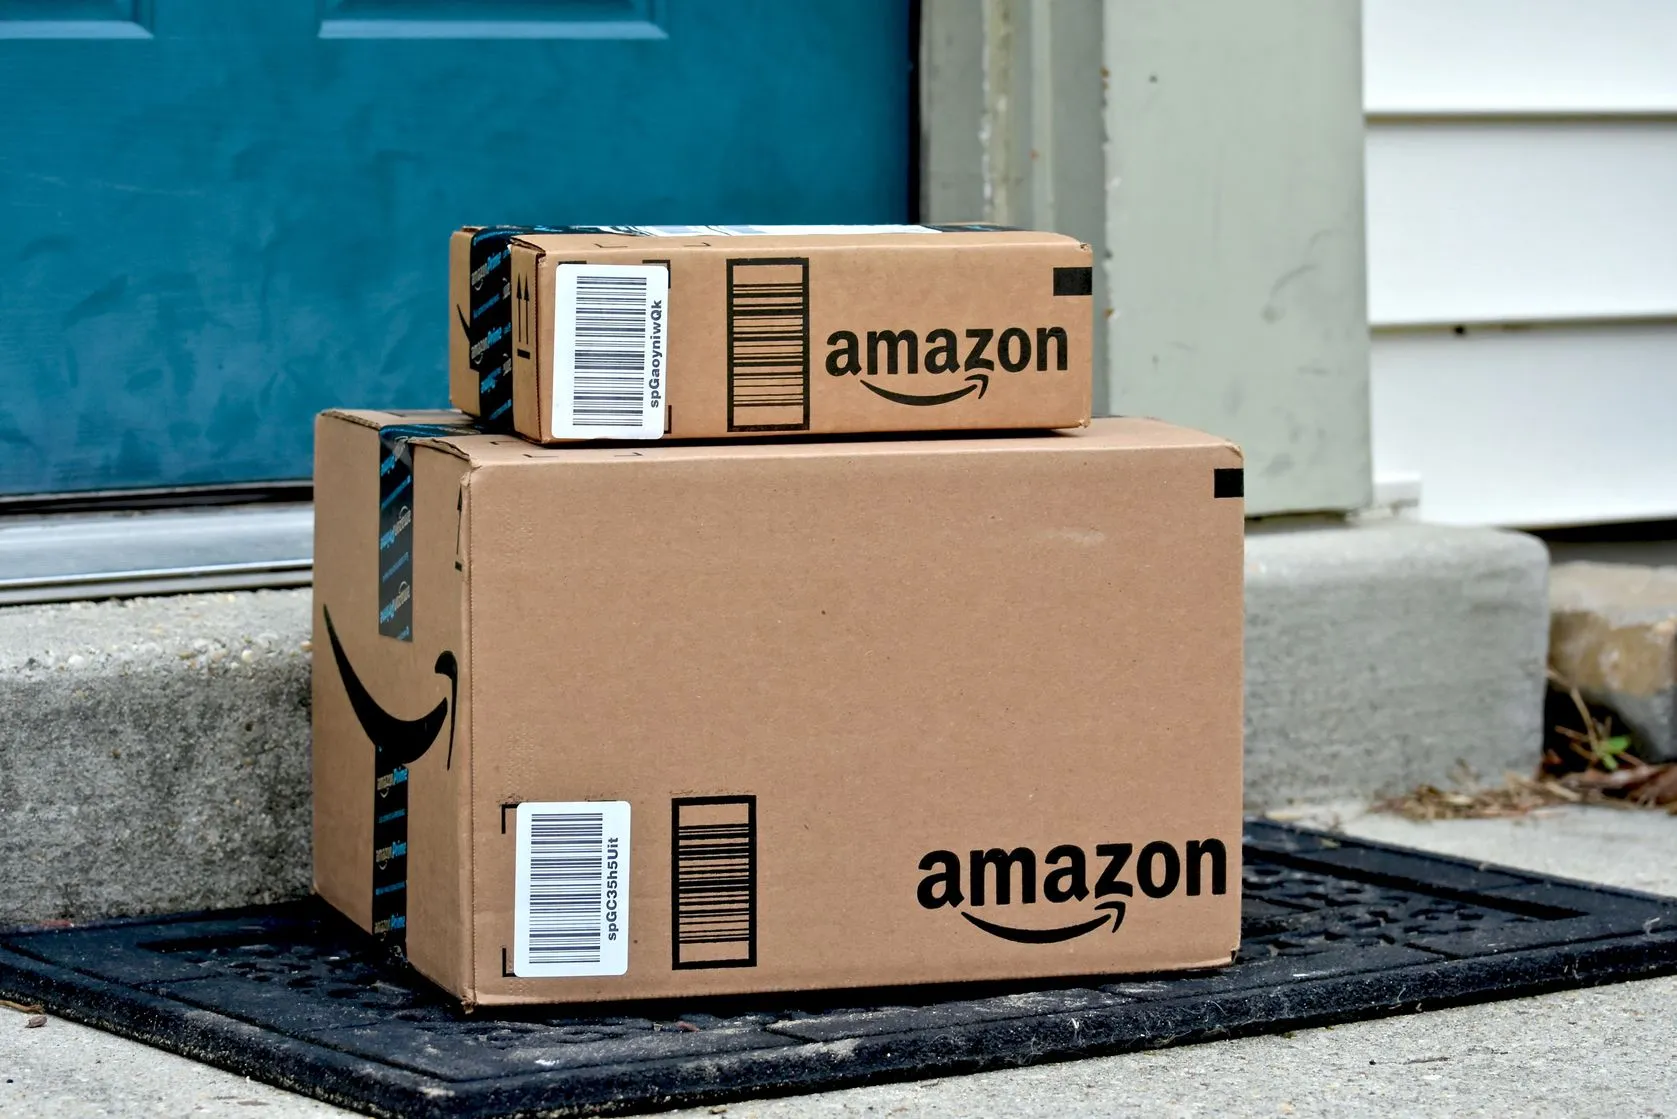

## <div style="color: lightgreen; font-size: 30; text-align: center"><b >Importing libraries and loading data</b></div>

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
from geopy.geocoders import Nominatim
from geopy.distance import great_circle
import threading
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from shapely.geometry import Point
import os
tqdm.pandas(colour='maroon')

In [ ]:
df = pd.read_csv('../Amazon Delivery Dataset/amazon_delivery.csv')

## <div style="color: green; font-size: 30px; text-align: center"><b>Univariate Analyses</b ></div>

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Preparing Data</b ></div>

In [ ]:
df.sample(4, random_state=0)

In [ ]:
ff.create_table(df.describe().reset_index().rename({'index': 'Calculated value'}, axis = 1))

In [ ]:
ff.create_table(df.select_dtypes('O').describe().reset_index().rename({'index': 'Calculated value'}, axis = 1))

In [ ]:
ff.create_table(df.mode().loc[0].drop(['Order_ID']).to_frame().reset_index().rename({'index':'Column name', 0:'Mode'}, axis = 1))

In [ ]:
ff.create_table((df.isnull().mean()*100).to_frame().reset_index().rename({0:'Percentage of null values', 'index':'Column name'} ,axis = 1))

In [ ]:
df.info()

In [ ]:
df.duplicated().sum()

In [ ]:
df['Order_ID'].duplicated().sum()

In [ ]:
ff.create_table(df.dtypes.to_frame().reset_index().rename({'index': 'Column name', 0: 'Data type'}, axis = 1))

In [ ]:
for columnName in df.select_dtypes('O').columns[1:]:
    print(columnName+':')
    display(df[columnName].unique())
    print('\n'+'-'*120+'\n')

In [ ]:
for columnName in df.select_dtypes('O').columns[1:]: # converting NaN as string and striping other strings
    print(columnName)
    df[columnName] = df[columnName].progress_apply(lambda x: (np.nan if 'nan' in x.casefold() else x.strip()) if isinstance(x, str) else x)

In [ ]:
df = df.convert_dtypes() # converting the data types

In [ ]:
ff.create_table((df.isnull().mean()*100).to_frame().reset_index().rename({0:'Percentage of null values', 'index':'Column name'} ,axis = 1))

In [ ]:
df_temp = df.sort_values(['Order_Date', 'Pickup_Time'], ignore_index=True)

In [ ]:
indexes_na = df_temp[df_temp.Order_Time.isnull()].index

In [ ]:
df_temp.loc[indexes_na[0]-2:indexes_na[0]+2]

In [ ]:
df_temp[(df_temp.Order_Time.isnull()) & (df_temp.Weather.isnull()) & (df_temp.Traffic.isnull())].shape[0]/df_temp.shape[0]*100

In [ ]:
df.dropna(subset=['Order_Time', 'Agent_Rating'], inplace=True)

In [ ]:
del df_temp

In [ ]:
df['Order_Date_Time'] = pd.to_datetime(df.Order_Date + ' ' + df.Order_Time, format="%Y-%m-%d %H:%M:%S")

In [ ]:
df['Pickup_Time'] = pd.to_datetime(df.Pickup_Time, format="%H:%M:%S").dt.time

In [ ]:
df.drop(['Order_Date', 'Order_Time'], axis=1, inplace=True)

In [ ]:
ff.create_table(df.dtypes.to_frame().reset_index().rename({'index': 'Column name', 0: 'Data type'}, axis = 1))

In [ ]:
df.to_csv('../Amazon Delivery Dataset/amazon_delivery_cleaned.csv', index=False)

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 1st feature (Order_ID)</b ></div>

In [ ]:
df.Order_ID.str.len().unique() # Checks if the length of IDs is all equivalent

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 2nd feature (Agent_Age)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Agent_Age', text_auto=True, title='Number of agents per each Age', template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(yaxis_title='Number of Agents', xaxis_title='Age', xaxis={'categoryorder': 'total descending'})

In [ ]:
ff.create_distplot(hist_data=[df['Agent_Age']], group_labels=['Agent_Age'], histnorm='', show_hist=False, colors=['maroon']).update_layout(template="plotly_dark")

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 3rd feature (Agent_Rating)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Agent_Rating', text_auto=True, title='Number of agents per each Age', template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(yaxis_title='Number of Agents', xaxis_title='Age', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 8th feature (Pickup_Time)</b ></div>

In [ ]:
px.line(data_frame=df['Pickup_Time'].value_counts().sort_index(), y='count', title='Number of orders per pickup-time', template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(xaxis_title='Pickup time', yaxis_title='Number of orders')
# used y only because the index contains the pickuptime

#### <div style="color: yellow; font-size: 20px; text-align: center"><b>Extracting feature from the 8th feature (Pickup_Time)<br>and analysing it</b ></div>

In [ ]:
def daytime(data):
    if data.hour > 6 and data.hour < 12:
        return 'Morning'
    elif data.hour < 18:
        return 'Afternoon'
    elif data.hour < 22:
        return 'Evening'
    else:
        return 'Night'
    pass
df['Pickup_Daytime'] = df['Pickup_Time'].progress_apply(daytime)

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Pickup_Daytime', text_auto=True, title='Number of orders picked up per daytime', template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(yafxis_title='Number of orders', xaxis_title='Daytime', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 9th feature (Weather)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Weather', text_auto=True, title='Number of orders per weather state', template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(yaxis_title='Number of orders', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 10th feature (Traffic)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Traffic', text_auto=True, title='Number of orders per traffic state', template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(yaxis_title='Number of orders', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 11th feature (Vehicle)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Vehicle', text_auto=True, title='Number of orders per vehicle', template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(yaxis_title='Number of orders', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 12th feature (Area)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Area', text_auto=True, title='Number of orders per area type', template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(yaxis_title='Number of orders', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 13th feature (Delivery_Time)</b ></div>

In [ ]:
ff.create_distplot(hist_data=[df.Delivery_Time], group_labels=['Delivery_Time'], histnorm='', colors=['maroon'], show_hist=False).update_layout(template='plotly_dark')

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 14th feature (Category)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Category', text_auto=True, title='Number of orders per category', template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(yaxis_title='Number of orders', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 15th feature (Order_Date_Time)</b ></div>

In [ ]:
px.line(data_frame=df['Order_Date_Time'].value_counts().sort_index(), y='count', title='Number of orders in Date time series', template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(yaxis_title='Number of orders', xaxis_title='Order Date & Time')

#### <div style="color: yellow; font-size: 20px; text-align: center"><b>Extracting feature from the 15th feature (Order_Date_Time)<br>and analysing it</b ></div>

In [ ]:
df['Order_Daytime'] = df['Order_Date_Time'].progress_apply(daytime)

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Order_Daytime', text_auto=True, title='Number of orders ordered per daytime', template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(yaxis_title='Number of orders', xaxis_title='Daytime', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Box plotes of all numeric data</b ></div>

In [ ]:
px.box(data_frame=df, x=df.select_dtypes('number').columns, template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(yaxis_title='Features', xaxis_title='Values', yaxis={'categoryorder': 'total ascending'})

## <div style="color: green; font-size: 30px; text-align: center"><b>Bivariate Analyses</b ></div>

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Extracting features from 4th, 5th, 6th & 7th feature<br>(Store_Latitude, Store_Longitude & Drop_Latitude & Drop_Longitude)</b ></div>

In [ ]:
geoLocator = Nominatim(user_agent='free_user')

In [ ]:
def extract_geo_data_store(df):
    while True:
        try:
            temp = geoLocator.reverse(f'{df['Store_Latitude']}, {df['Store_Longitude']}')
            break
        except:
            pass
    if temp == None:
        return pd.Series({'Store_City_District': 'Unknown',
                      'Store_County': 'Unknown',
                      'Store_State_District': 'Unknown',
                      'Store_State': 'Unknown',
                      'Store_Postcode': np.nan,
                      'Store_Country': 'Unknown',
                      'Store_Type_Of_Location': 'Unknown'})
    data = temp.raw
    return pd.Series({'Store_City_District': data['address']['city_district'] if 'city_district' in data['address'] else 'Unknown',
                      'Store_County': data['address']['county'] if 'county' in data['address'] else 'Unknown',
                      'Store_State_District': data['address']['state_district'] if 'state_district' in data['address'] else 'Unknown',
                      'Store_State': data['address']['state'] if 'state' in data['address'] else 'Unknown',
                      'Store_Postcode': data['address']['postcode'] if 'postcode' in data['address'] else np.nan,
                      'Store_Country': data['address']['country'] if 'country' in data['address'] else 'Unknown',
                      'Store_Type_Of_Location': data['type']})

In [ ]:
def extract_geo_data_drop(df):
    while True:
        try:
            temp = geoLocator.reverse(f'{df['Drop_Latitude']}, {df['Drop_Longitude']}')
            break
        except:
            pass
    if temp == None:
        return pd.Series({'Drop_City_District': 'Unknown',
                      'Drop_County': 'Unknown',
                      'Drop_State_District': 'Unknown',
                      'Drop_State': 'Unknown',
                      'Drop_Postcode': np.nan,
                      'Drop_Country': 'Unknown',
                      'Drop_Type_Of_Location': 'Unknown'})
    data = temp.raw
    return pd.Series({'Drop_City_District': data['address']['city_district'] if 'city_district' in data['address'] else 'Unknown',
                      'Drop_County': data['address']['county'] if 'county' in data['address'] else 'Unknown',
                      'Drop_State_District': data['address']['state_district'] if 'state_district' in data['address'] else 'Unknown',
                      'Drop_State': data['address']['state'] if 'state' in data['address'] else 'Unknown',
                      'Drop_Postcode': data['address']['postcode'] if 'postcode' in data['address'] else np.nan,
                      'Drop_Country': data['address']['country'] if 'country' in data['address'] else 'Unknown',
                      'Drop_Type_Of_Location': data['type']})

In [ ]:
class MyThread(threading.Thread): # creating a class that inherits threads class to make join function return the value of my targeted function
    def __init__(self, target, args=()):
        super().__init__()
        self._target = target
        self._args = args
        self._return = None
    def run(self):
        self._return = self._target(*self._args)

    def join(self):
        threading.Thread.join(self)
        return self._return

def thread_apply(df, columns, funcion_to_apply):
    return df[columns].progress_apply(funcion_to_apply, axis = 1)

In [ ]:
# thread_store = MyThread(target=thread_apply, args=(df.copy(), ['Store_Latitude', 'Store_Longitude'], extract_geo_data_store))
# thread_drop = MyThread(target=thread_apply, args=(df.copy(), ['Drop_Latitude', 'Drop_Longitude'], extract_geo_data_drop))
# thread_store.start()
# thread_drop.start()

In [ ]:
# df_temp_store = thread_store.join()
# df_temp_drop = thread_drop.join()

In [ ]:
df['Distance'] = df[['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude']].progress_apply(lambda df: great_circle(df[['Store_Latitude', 'Store_Longitude']], df[['Drop_Latitude', 'Drop_Longitude']]).kilometers, axis = 1)

In [ ]:
# df = pd.concat([df, df_temp_store, df_temp_drop], axis=1)
# df.to_csv('../Amazon Delivery Dataset/amazon_delivery_cleaned_and_extracted_features.csv', index=True)
# df.to_pickle('../Amazon Delivery Dataset/amazon_delivery_cleaned_and_extracted_features_binary.pkl') #save pandas object in binary

In [ ]:
df = pd.read_pickle('../Amazon Delivery Dataset/amazon_delivery_cleaned_and_extracted_features_binary.pkl') #read pickle binary object

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Checking for null or unknown values from the just extracted feature</b ></div>

In [ ]:
center_lat = (df['Drop_Latitude'].mean() + df['Store_Latitude'].mean())/2
center_lon = (df['Drop_Longitude'].mean() + df['Store_Longitude'].mean())/2
mymap = folium.Map(location=[center_lat, center_lon], zoom_start=2, tiles='CartoDB dark_matter')
marker_cluster = MarkerCluster().add_to(mymap)
def markers(row):
    folium.Marker(
        location=[row['Store_Latitude'], row['Store_Longitude']],
        popup=f"Lat: {row['Store_Latitude']}<br>Lon: {row['Store_Longitude']}",
        tooltip=f"{row['Order_ID']}",
        icon=folium.Icon(color='darkred', icon='fa-solid fa-store', icon_color='white', prefix = 'fa')
    ).add_to(marker_cluster)
    folium.Marker(
        location=[row['Drop_Latitude'], row['Drop_Longitude']],
        popup=f"Lat: {row['Drop_Latitude']}<br>Lon: {row['Drop_Longitude']}",
        tooltip=f"{row['Order_ID']}",
        icon=folium.Icon(color='darkred', icon='fa-solid fa-truck-ramp-box', icon_color='white', prefix = 'fa')
    ).add_to(marker_cluster)

df.progress_apply(markers, axis = 1)
mymap

In [ ]:
df[df['Store_Type_Of_Location'] == 'Unknown'].shape[0]

In [ ]:
df[df['Store_Country'] == 'Unknown'].shape[0] + df[df['Drop_Country'] == 'Unknown'].shape[0]

In [ ]:
center_lat_store = df['Store_Latitude'].mean()
center_lon_store = df['Store_Longitude'].mean()
mymap_store = folium.Map(location=[center_lat_store, center_lon_store], zoom_start=2, tiles='CartoDB dark_matter')
marker_cluster_store = MarkerCluster(name='Store location').add_to(mymap_store)
center_lat_drop = df['Drop_Latitude'].mean()
center_lon_drop = df['Drop_Longitude'].mean()
mymap_drop = folium.Map(location=[center_lat_drop, center_lon_drop], zoom_start=2, tiles='CartoDB dark_matter')
marker_cluster_drop = MarkerCluster(name='Drop location').add_to(mymap_drop)
def markers(row):
    folium.Marker(
        location=[row['Store_Latitude'], row['Store_Longitude']],
        popup=f"Lat: {row['Store_Latitude']}<br>Lon: {row['Store_Longitude']}",
        tooltip=f"{row['Order_ID']}",
        icon=folium.Icon(color='darkred', icon='fa-solid fa-store', icon_color='white', prefix = 'fa')
    ).add_to(marker_cluster_store)
    folium.Marker(
        location=[row['Drop_Latitude'], row['Drop_Longitude']],
        popup=f"Lat: {row['Drop_Latitude']}<br>Lon: {row['Drop_Longitude']}",
        tooltip=f"{row['Order_ID']}",
        icon=folium.Icon(color='darkred', icon='fa-solid fa-truck-ramp-box', icon_color='white', prefix = 'fa')
    ).add_to(marker_cluster_drop)
df1 = df[df['Store_Country'] == 'Unknown']
df2 = df[df['Drop_Country'] == 'Unknown']
df3 = df[df['Store_Type_Of_Location'] == 'Unknown']
df_temp = pd.concat([df1, df2, df3]).drop_duplicates()
df_temp.progress_apply(markers, axis = 1)
del df1, df2, df3
display(mymap_store, mymap_drop)

In [ ]:
(df_temp.shape[0]/df.shape[0])*100

In [ ]:
(df_temp[(df_temp['Drop_Type_Of_Location'] != 'Unknown') & (df_temp['Drop_Country'] != 'Unknown')].shape[0]/df.shape[0])*100

In [ ]:
((df_temp.shape[0]-151)/df.shape[0])*100

In [ ]:
df.drop(df_temp.index, inplace = True)
del df_temp

In [ ]:
center_lat = (df['Drop_Latitude'].mean() + df['Store_Latitude'].mean())/2
center_lon = (df['Drop_Longitude'].mean() + df['Store_Longitude'].mean())/2
mymap = folium.Map(location=[center_lat, center_lon], zoom_start=2, tiles='CartoDB dark_matter')
marker_cluster = MarkerCluster().add_to(mymap)
def markers(row):
    folium.Marker(
        location=[row['Store_Latitude'], row['Store_Longitude']],
        popup=f"Lat: {row['Store_Latitude']}<br>Lon: {row['Store_Longitude']}",
        tooltip=f"{row['Order_ID']}",
        icon=folium.Icon(color='darkred', icon='fa-solid fa-store', icon_color='white', prefix = 'fa')
    ).add_to(marker_cluster)
    folium.Marker(
        location=[row['Drop_Latitude'], row['Drop_Longitude']],
        popup=f"Lat: {row['Drop_Latitude']}<br>Lon: {row['Drop_Longitude']}",
        tooltip=f"{row['Order_ID']}",
        icon=folium.Icon(color='darkred', icon='fa-solid fa-truck-ramp-box', icon_color='white', prefix = 'fa')
    ).add_to(marker_cluster)
df.progress_apply(markers, axis = 1)
mymap

In [ ]:
land = gpd.read_file('../ne_10m_land/ne_10m_land.shp')
def is_on_land(lat, lon):
    point = Point(lon, lat)
    return land.contains(point).any()
def thread_apply(df, columns):
    return df[columns].progress_apply(lambda x: is_on_land(x.iloc[0], x.iloc[1]), axis = 1)

In [ ]:
thread_store = MyThread(target=thread_apply, args=(df.copy(), ['Store_Latitude', 'Store_Longitude']))
thread_drop = MyThread(target=thread_apply, args=(df.copy(), ['Drop_Latitude', 'Drop_Longitude']))
thread_store.start()
thread_drop.start()

In [ ]:
filter_store = thread_store.join()
filter_drop = thread_drop.join()

In [ ]:
(df[~filter_store | ~filter_drop].shape[0]/df.shape[0])*100

In [ ]:
df.drop(df[~filter_store | ~filter_drop].index, inplace = True)

In [ ]:
# df.to_csv('../Amazon Delivery Dataset/amazon_delivery_cleaned_and_extracted_features_final_on_land.csv', index=True)
# df.to_pickle('../Amazon Delivery Dataset/amazon_delivery_cleaned_and_extracted_features_binary_on_land.pkl') #save pandas object in binary

In [ ]:
df = pd.read_pickle('../Amazon Delivery Dataset/amazon_delivery_cleaned_and_extracted_features_binary_on_land.pkl') #read pickle binary object

In [ ]:
center_lat = (df['Drop_Latitude'].mean() + df['Store_Latitude'].mean())/2
center_lon = (df['Drop_Longitude'].mean() + df['Store_Longitude'].mean())/2
mymap = folium.Map(location=[center_lat, center_lon], zoom_start=2, tiles='CartoDB dark_matter')
marker_cluster = MarkerCluster().add_to(mymap)
def markers(row):
    folium.Marker(
        location=[row['Store_Latitude'], row['Store_Longitude']],
        popup=f"Lat: {row['Store_Latitude']}<br>Lon: {row['Store_Longitude']}",
        tooltip=f"{row['Order_ID']}",
        icon=folium.Icon(color='darkred', icon='fa-solid fa-store', icon_color='white', prefix = 'fa')
    ).add_to(marker_cluster)
    folium.Marker(
        location=[row['Drop_Latitude'], row['Drop_Longitude']],
        popup=f"Lat: {row['Drop_Latitude']}<br>Lon: {row['Drop_Longitude']}",
        tooltip=f"{row['Order_ID']}",
        icon=folium.Icon(color='darkred', icon='fa-solid fa-truck-ramp-box', icon_color='white', prefix = 'fa')
    ).add_to(marker_cluster)

df.progress_apply(markers, axis = 1)
mymap

In [ ]:
rivers = gpd.read_file('../ne_10m_rivers_lake_centerlines_scale_rank/ne_10m_rivers_lake_centerlines_scale_rank.shp')
def is_on_rivers(lat, lon):
    point = Point(lon, lat)
    return rivers.contains(point).any()
def thread_apply(df, columns):
    return df[columns].progress_apply(lambda x: is_on_rivers(x.iloc[0], x.iloc[1]), axis = 1)

In [ ]:
thread_store = MyThread(target=thread_apply, args=(df.copy(), ['Store_Latitude', 'Store_Longitude']))
thread_drop = MyThread(target=thread_apply, args=(df.copy(), ['Drop_Latitude', 'Drop_Longitude']))
thread_store.start()
thread_drop.start()

In [ ]:
filter_store = thread_store.join()
filter_drop = thread_drop.join()

In [ ]:
df[filter_store | filter_drop]

In [ ]:
# lakes = gpd.read_file('../ne_10m_lakes/ne_10m_lakes.shp')
# def is_on_lakes(lat, lon):
#     point = Point(lon, lat)
#     return lakes.contains(point).any()
# def thread_apply(df, columns):
#     return df[columns].progress_apply(lambda x: is_on_lakes(x.iloc[0], x.iloc[1]), axis = 1)

In [ ]:
# thread_store = MyThread(target=thread_apply, args=(df.copy(), ['Store_Latitude', 'Store_Longitude']))
# thread_drop = MyThread(target=thread_apply, args=(df.copy(), ['Drop_Latitude', 'Drop_Longitude']))
# thread_store.start()
# thread_drop.start()

In [ ]:
# filter_store = thread_store.join()
# filter_drop = thread_drop.join()

In [ ]:
# df[filter_store | filter_drop]

In [ ]:
# filter_store = list()
# filter_drop = list()
# for index, zone in enumerate(os.listdir('../gis/')):
#     water1 = gpd.read_file(f'../gis/{zone}/gis_osm_water_a_free_1.shp')
#     water2 = gpd.read_file(f'../gis/{zone}/gis_osm_waterways_free_1.shp')
#     def is_on_water(lat, lon):
#         point = Point(lon, lat)
#         return any((water1.contains(point).any(), water2.contains(point).any()))
#     def thread_apply(df, columns):
#         return df[columns].progress_apply(lambda x: is_on_water(x.iloc[0], x.iloc[1]), axis = 1)
#     thread_store = MyThread(target=thread_apply, args=(df.copy(), ['Store_Latitude', 'Store_Longitude']))
#     thread_drop = MyThread(target=thread_apply, args=(df.copy(), ['Drop_Latitude', 'Drop_Longitude']))
#     thread_store.start()
#     thread_drop.start()
#     filter_store.append(thread_store.join())
#     filter_drop.append(thread_drop.join())

In [ ]:
# filter_drop_all = filter_drop[0]
# for f in filter_drop[1:]:
#     filter_drop_all |= f
# filter_drop_all.value_counts()

In [ ]:
# filter_store_all = filter_store[0]
# for f in filter_store[1:]:
#     filter_store_all |= f
# filter_store_all.value_counts()

In [ ]:
# (df[filter_store_all | filter_drop_all].shape[0]/df.shape[0])*100

In [ ]:
# df.drop(df[filter_store_all | filter_drop_all].index, inplace = True)

In [ ]:
# df.to_csv('../Amazon Delivery Dataset/amazon_delivery_cleaned_and_extracted_features_final.csv', index=False)
# df.to_pickle('../Amazon Delivery Dataset/amazon_delivery_cleaned_and_extracted_features_binary_final.pkl') #save pandas object in binary

In [8]:
df = pd.read_pickle('../Amazon Delivery Dataset/amazon_delivery_cleaned_and_extracted_features_binary_final.pkl') #read pickle binary object

In [ ]:
1center_lat = (df['Drop_Latitude'].mean() + df['Store_Latitude'].mean())/2
center_lon = (df['Drop_Longitude'].mean() + df['Store_Longitude'].mean())/2
mymap = folium.Map(location=[center_lat, center_lon], zoom_start=2, tiles='CartoDB dark_matter')
marker_cluster = MarkerCluster().add_to(mymap)
def markers(row):
    folium.Marker(
        location=[row['Store_Latitude'], row['Store_Longitude']],
        popup=f"Lat: {row['Store_Latitude']}<br>Lon: {row['Store_Longitude']}",
        tooltip=f"{row['Order_ID']}",
        icon=folium.Icon(color='darkred', icon='fa-solid fa-store', icon_color='white', prefix = 'fa')
    ).add_to(marker_cluster)
    folium.Marker(
        location=[row['Drop_Latitude'], row['Drop_Longitude']],
        popup=f"Lat: {row['Drop_Latitude']}<br>Lon: {row['Drop_Longitude']}",
        tooltip=f"{row['Order_ID']}",
        icon=folium.Icon(color='darkred', icon='fa-solid fa-truck-ramp-box', icon_color='white', prefix = 'fa')
    ).add_to(marker_cluster)

df.progress_apply(markers, axis = 1)
mymap

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 2nd & 3rd feature (Agent_Age & Agent_Rating)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Agent_Age', y='Agent_Rating', text_auto=True, histfunc='avg', title='Average rating of orders per agents age', template='plotly_dark', color_discrete_sequence=['maroon']).update_layout(yaxis_title='Rating', xaxis_title='Age', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 2nd & 14th feature (Agent_Age & Category)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Agent_Age', color='Category', text_auto=True, title='Number of orders per each age of agent for each category', template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Bold+px.colors.qualitative.Dark2, height=600).update_layout(yaxis_title='Number of orders', xaxis_title='Age', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 2nd & extracted feature (Agent_Age & Order_Daytime)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Agent_Age', color='Order_Daytime', text_auto=True, title='Number of orders per each age of agent for along daytime', template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Bold+px.colors.qualitative.Dark2).update_layout(yaxis_title='Number of orders', xaxis_title='Age', legend_title='Daytime', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 10th & 11th feature (Traffic & Vehicle)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Traffic', color='Vehicle', text_auto=True, title='Number of orders per each Traffic state for each vehicle', template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Bold+px.colors.qualitative.Dark2, barmode='group').update_layout(yaxis_title='Number of orders', xaxis_title='Traffic',legend_title='Vehicle', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 10th & 12th features (Traffic & Area)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Traffic', color='Area', text_auto=True, title='Number of orders per each Traffic state for each area type', template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Bold+px.colors.qualitative.Dark2, barmode='group').update_layout(yaxis_title='Number of orders', xaxis_title='Traffic',legend_title='Area type', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 8th & 10th features (Pickup_Time & Traffic)</b ></div>

In [ ]:
px.line(df.pivot_table(values='Traffic', index='Pickup_Time', aggfunc='count').sort_index(), y='Traffic', template='plotly_dark', color_discrete_sequence=['maroon'], title = 'Number of orders per each traffic along pickup time series').update_layout(xaxis_title='Pickup time')

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 6th & 7th features and extracted features from them (Drop_Latitude & Drop_Longitude)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Drop_Country', color='Drop_State', text_auto=True, title='Number of drop locations per each country per each state', template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Bold+px.colors.qualitative.Dark2, barmode='group').update_layout(yaxis_title='Number of drop locations', xaxis_title='Country',legend_title='State', xaxis={'categoryorder': 'total descending'})

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring 4th & 5th features and extracted features from them (Store_Latitude & Store_Longitude)</b ></div>

In [ ]:
px.histogram(data_frame=df.astype('string'), x='Store_Country', color='Store_State', text_auto=True, title='Number of store locations per each country per each state', template='plotly_dark', color_discrete_sequence=px.colors.qualitative.Bold+px.colors.qualitative.Dark2, barmode='group').update_layout(yaxis_title='Number of store locations', xaxis_title='Country',legend_title='State', xaxis={'categoryorder': 'total descending'})

## <div style="color: green; font-size: 30px; text-align: center"><b>Multivariate Analyses</b ></div>

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Correlation between all numeric features</b ></div>

In [ ]:
px.imshow(df.select_dtypes('number').corr().rename({i:i.replace('_', ' ') for i in df.select_dtypes('number').columns}).rename({i:i.replace('_', ' ') for i in df.select_dtypes('number').columns}, axis = 1), template='plotly_dark', title='Correlation between numeric features', text_auto=True, color_continuous_scale=px.colors.colorbrewer.RdGy_r, height=600)

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Scatter plot between some numeric features</b ></div>

In [ ]:
px.scatter_matrix(data_frame=df.rename({'Delivery_Time':'Delivery Time', 'Agent_Rating':'Agent Rating', 'Agent_Age':'Agent Age'}, axis = 1), dimensions=['Agent Age', 'Agent Rating', 'Delivery Time', 'Distance'], template='plotly_dark',color='Traffic', symbol='Area', height=600)

### <div style="color: lightgreen; font-size: 24px; text-align: center"><b>Exploring Features</b ></div>

In [ ]:
px.treemap(df, path=['Store_Type_Of_Location', 'Category'], title='Treemap of Store Types and Delivery Categories', template='plotly_dark', height=700, color_discrete_sequence=px.colors.qualitative.Bold)

In [ ]:
px.sunburst(df, path=['Store_Country', 'Store_State', 'Store_City_District'], title='Store Locations', template = 'plotly_dark', height=700, color_discrete_sequence=px.colors.qualitative.Dark24)

In [ ]:
px.sunburst(df, path=['Drop_Country', 'Drop_State', 'Drop_City_District'], title='Drop Locations', template = 'plotly_dark', height=700, color_discrete_sequence= px.colors.qualitative.Dark24_r)

In [10]:
df['Drop_icon'] = 'place'
df['Store_icon'] = 'cart'

In [11]:
df.columns = df.columns.str.replace('_', ' ')

In [12]:
df['Pickup Time'] = pd.to_datetime(df['Pickup Time'].apply(str), format='%H:%M:%S')

In [13]:
df['Arrival Time'] = df['Pickup Time'] + pd.to_timedelta(df['Delivery Time'], unit='m')

In [14]:
df.columns

Index(['Order ID', 'Agent Age', 'Agent Rating', 'Store Latitude',
       'Store Longitude', 'Drop Latitude', 'Drop Longitude', 'Pickup Time',
       'Weather', 'Traffic', 'Vehicle', 'Area', 'Delivery Time', 'Category',
       'Order Date Time', 'Pickup Daytime', 'Order Daytime', 'Distance',
       'Store City District', 'Store County', 'Store State District',
       'Store State', 'Store Postcode', 'Store Country',
       'Store Type Of Location', 'Drop City District', 'Drop County',
       'Drop State District', 'Drop State', 'Drop Postcode', 'Drop Country',
       'Drop Type Of Location', 'Drop icon', 'Store icon', 'Arrival Time'],
      dtype='object')

In [15]:
df.rename({'Order Date Time':'Order Date & Time'}, inplace=True, axis = 1)

In [16]:
df.reset_index(inplace=True, drop=True)

In [17]:
df.to_csv('../Amazon Delivery Dataset/amazon_delivery_cleaned_and_extracted_features_final_kepler.csv', index=False)
df.to_pickle('../Amazon Delivery Dataset/amazon_delivery_cleaned_and_extracted_features_final_kepler.pkl')